In [1]:
import os
import shutil
import tarfile
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
# Get the current working directory
current_folder = os.getcwd()

dataset = tf.keras.utils.get_file(fname ="aclImdb.tar.gz", origin ="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",cache_dir=  current_folder,extract = True)

84125825/84125825 [==============================] - 3s 0us/step


In [3]:
dataset_path = os.path.dirname(dataset)
print(dataset_path)
# Check the dataset
os.listdir(dataset_path)

/content/datasets


['aclImdb.tar.gz', 'aclImdb']

In [4]:
# Dataset directory
dataset_dir = os.path.join(dataset_path, 'aclImdb')

# Check the Dataset directory
os.listdir(dataset_dir)

['README', 'train', 'imdbEr.txt', 'imdb.vocab', 'test']

In [5]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'pos',
 'neg',
 'urls_pos.txt',
 'unsupBow.feat',
 'urls_neg.txt',
 'labeledBow.feat',
 'unsup']

In [6]:
test_dir = os.path.join(dataset_dir,'test')
os.listdir(test_dir)

['pos', 'neg', 'urls_pos.txt', 'urls_neg.txt', 'labeledBow.feat']

In [7]:
for file in os.listdir(train_dir):
    file_path = os.path.join(train_dir, file)
    # Check if it's a file (not a directory)
    if os.path.isfile(file_path):
        with open(file_path, 'r', encoding='utf-8') as f:
            first_value = f.readline().strip()
            print(f"{file}: {first_value}")
    else:
        print(f"{file}: {file_path}")

urls_unsup.txt: http://www.imdb.com/title/tt0018515/usercomments
pos: /content/datasets/aclImdb/train/pos
neg: /content/datasets/aclImdb/train/neg
urls_pos.txt: http://www.imdb.com/title/tt0453418/usercomments
unsupBow.feat: 0 0:8 1:6 3:5 4:2 5:1 7:1 8:5 9:2 10:1 11:2 13:3 16:1 17:1 18:1 19:1 22:3 24:1 26:3 28:1 30:1 31:1 35:2 36:1 39:2 40:1 41:2 46:2 47:1 48:1 52:1 63:1 67:1 68:1 74:1 81:1 83:1 87:1 104:1 105:1 112:1 117:1 131:1 151:1 155:1 170:1 198:1 225:1 226:1 288:2 291:1 320:1 331:1 342:1 364:1 374:1 384:2 385:1 407:1 437:1 441:1 465:1 468:1 470:1 519:1 595:1 615:1 650:1 692:1 851:1 937:1 940:1 1100:1 1264:1 1297:1 1317:1 1514:1 1728:1 1793:1 1948:1 2088:1 2257:1 2358:1 2584:2 2645:1 2735:1 3050:1 4297:1 5385:1 5858:1 7382:1 7767:1 7773:1 9306:1 10413:1 11881:1 15907:1 18613:1 18877:1 25479:1
urls_neg.txt: http://www.imdb.com/title/tt0064354/usercomments
labeledBow.feat: 9 0:9 1:1 2:4 3:4 4:6 5:4 6:2 7:2 8:4 10:4 12:2 26:1 27:1 28:1 29:2 32:1 41:1 45:1 47:1 50:1 54:2 57:1 59:1 63

In [8]:
def load_dataset(directory):
    data = {"sentence": [], "sentiment": []}
    for file_name in os.listdir(directory):
        print(file_name)
        if file_name == 'pos':
            positive_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(positive_dir):
                text = os.path.join(positive_dir, text_file)
                with open(text, "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(1)
        elif file_name == 'neg':
            negative_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(negative_dir):
                text = os.path.join(negative_dir, text_file)
                with open(text, "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(0)

    return pd.DataFrame.from_dict(data)

In [9]:
# Load the dataset from the train_dir
train_df = load_dataset(train_dir)
print(train_df.head())

urls_unsup.txt
pos
neg
urls_pos.txt
unsupBow.feat
urls_neg.txt
labeledBow.feat
unsup
                                            sentence  sentiment
0  Farrah Fawcett has spent the better part of he...          1
1  My daughter, her friends and I have watched th...          1
2  After seeing Dick Tracy in the 6.99$ bin at Fu...          1
3  The Lion King 1 1/2 is a very cute story to go...          1
4  If you are a fan, then you will probably enjoy...          1


In [11]:
train_df.shape

(25000, 2)

In [13]:
train_df['sentiment'].value_counts()

,count
sentiment,
1,12500
0,12500


In [10]:
# Load the dataset from the train_dir
test_df = load_dataset(test_dir)
print(test_df.head())

pos
neg
urls_pos.txt
urls_neg.txt
labeledBow.feat
                                            sentence  sentiment
0  The trio are a pleasant, nostalgic journey to ...          1
1  In the 60's Cleveland television audiences cou...          1
2  I cry at a lot of movies. Call me sentimental....          1
3  If someone had nudged me about 15 minutes into...          1
4  This is a pretty obscure, dumb horror movie se...          1


In [12]:
test_df.shape

(25000, 2)

In [14]:
test_df['sentiment'].value_counts()

,count
sentiment,
1,12500
0,12500


In [15]:
sentiment_counts = train_df['sentiment'].value_counts()

fig =px.bar(x= {0:'Negative',1:'Positive'}, y= sentiment_counts.values, color=sentiment_counts.index,
                                                 color_discrete_sequence =  px.colors.qualitative.Dark24, title='<b>Sentiments Counts')

fig.update_layout(title='Sentiments Counts', xaxis_title='Sentiment', yaxis_title='Counts', template='plotly_dark')

# Show the bar chart
fig.show()
pyo.plot(fig, filename = 'Sentiments Counts.html', auto_open = True)

'Sentiments Counts.html'

In [16]:
def text_cleaning(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub(r'\[[^]]*\]', '', soup.get_text())
    pattern = r"[^a-zA-Z0-9\s,']"
    text = re.sub(pattern, '', text)
    return text

In [17]:
train_df['sentence'][0]

"Farrah Fawcett has spent the better part of her post-Angel's career confounding us, with an occasional noteworthy acting performance sandwiched in between her Playboy frolics and Letterman escapades. But when it comes down to it, there's no denying that this girl can act. Far from a story of epic proportions, this well-done TV-movie is gentle, quiet and occasionally moving. Fawcett plays the wayward black sheep daughter come home only to find that she missed the last days of her mom's life as well as the funeral, much to the chagrin of her more stable and presumably more sensible sister. Brad Johnson plays the love interest, and a story unfolds with all the typical elements of telefilm drama- but then there's always that confounding Farrah to watch, and she does, indeed, remain eminently watchable. (And, yes, I admit it, I did have that Farrah poster on my wall way back when). Silk Hope gets three and a half stars (out of five) on the Corkymeter. Bosley would be proud."

In [18]:
# Train dataset
train_df['Cleaned_sentence'] = train_df['sentence'].apply(text_cleaning).tolist()
# Test dataset
test_df['Cleaned_sentence'] = test_df['sentence'].apply(text_cleaning)

In [19]:
train_df.head()

,sentence,sentiment,Cleaned_sentence
0,Farrah Fawcett has spent the better part of he...,1,Farrah Fawcett has spent the better part of he...
1,"My daughter, her friends and I have watched th...",1,"My daughter, her friends and I have watched th..."
2,After seeing Dick Tracy in the 6.99$ bin at Fu...,1,After seeing Dick Tracy in the 699 bin at Futu...
3,The Lion King 1 1/2 is a very cute story to go...,1,The Lion King 1 12 is a very cute story to go ...
4,"If you are a fan, then you will probably enjoy...",1,"If you are a fan, then you will probably enjoy..."


In [20]:
train_df['Cleaned_sentence'][0]

"Farrah Fawcett has spent the better part of her postAngel's career confounding us, with an occasional noteworthy acting performance sandwiched in between her Playboy frolics and Letterman escapades But when it comes down to it, there's no denying that this girl can act Far from a story of epic proportions, this welldone TVmovie is gentle, quiet and occasionally moving Fawcett plays the wayward black sheep daughter come home only to find that she missed the last days of her mom's life as well as the funeral, much to the chagrin of her more stable and presumably more sensible sister Brad Johnson plays the love interest, and a story unfolds with all the typical elements of telefilm drama but then there's always that confounding Farrah to watch, and she does, indeed, remain eminently watchable And, yes, I admit it, I did have that Farrah poster on my wall way back when Silk Hope gets three and a half stars out of five on the Corkymeter Bosley would be proud"

In [21]:
# Function to generate word cloud
def generate_wordcloud(text,Title):
    all_text = " ".join(text)
    wordcloud = WordCloud(width=800,  height=400, stopwords=set(STOPWORDS),  background_color='black').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(Title)
    plt.show()

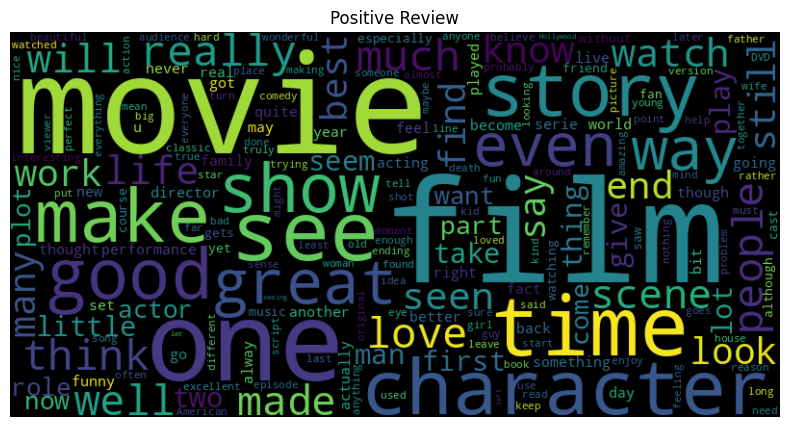

In [22]:
positive = train_df[train_df['sentiment']==1]['Cleaned_sentence'].tolist()
generate_wordcloud(positive,'Positive Review')

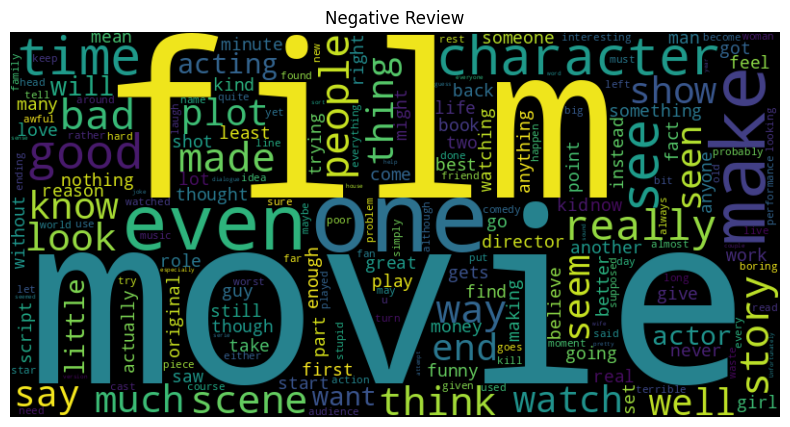

In [23]:
negative = train_df[train_df['sentiment']==0]['Cleaned_sentence'].tolist()
generate_wordcloud(negative,'Negative Review')

In [24]:
# Training data
#Reviews = "[CLS] " +train_df['Cleaned_sentence'] + "[SEP]"
Reviews = train_df['Cleaned_sentence']
Target = train_df['sentiment']

# Test data
#test_reviews =  "[CLS] " +test_df['Cleaned_sentence'] + "[SEP]"
test_reviews = test_df['Cleaned_sentence']
test_targets = test_df['sentiment']

In [25]:
x_val, x_test, y_val, y_test = train_test_split(test_reviews, test_targets, test_size=0.5,  stratify = test_targets)

In [26]:
x_val.shape, x_test.shape

((12500,), (12500,))

In [27]:
#Tokenize and encode the data using the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [28]:
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [29]:
max_len= 128
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(Reviews.tolist(), padding=True,  truncation=True, max_length = max_len, return_tensors='tf')

X_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(),  padding=True,  truncation=True, max_length = max_len, return_tensors='tf')

X_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(),  padding=True,  truncation=True, max_length = max_len, return_tensors='tf')

In [30]:
k = 0
print('Training Comments -->>',Reviews[k])
print('\nInput Ids -->>\n',X_train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer.decode(X_train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',X_train_encoded['attention_mask'][k])
print('\nLabels -->>',Target[k])

Training Comments -->> Farrah Fawcett has spent the better part of her postAngel's career confounding us, with an occasional noteworthy acting performance sandwiched in between her Playboy frolics and Letterman escapades But when it comes down to it, there's no denying that this girl can act Far from a story of epic proportions, this welldone TVmovie is gentle, quiet and occasionally moving Fawcett plays the wayward black sheep daughter come home only to find that she missed the last days of her mom's life as well as the funeral, much to the chagrin of her more stable and presumably more sensible sister Brad Johnson plays the love interest, and a story unfolds with all the typical elements of telefilm drama but then there's always that confounding Farrah to watch, and she does, indeed, remain eminently watchable And, yes, I admit it, I did have that Farrah poster on my wall way back when Silk Hope gets three and a half stars out of five on the Corkymeter Bosley would be proud

Input Id

In [31]:
# Intialize the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
model

In [32]:
# Compile the model with an appropriate optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
# Step 5: Train the model
history = model.fit([X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']], Target,
                             validation_data=([X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val),batch_size=32,epochs=3)

In [ ]:
#Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate([X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],y_test)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

In [ ]:
path = '/content'
# Save tokenizer
tokenizer.save_pretrained(path +'/Tokenizer')

# Save model
model.save_pretrained(path +'/Model')

In [ ]:
# Load tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(path +'/Tokenizer')

# Load model
bert_model = TFBertForSequenceClassification.from_pretrained(path +'/Model')

In [ ]:
pred = bert_model.predict([X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])

# pred is of type TFSequenceClassifierOutput
logits = pred.logits

# Use argmax along the appropriate axis to get the predicted labels
pred_labels = tf.argmax(logits, axis=1)

# Convert the predicted labels to a NumPy array
pred_labels = pred_labels.numpy()

label = {1: 'positive', 0: 'Negative' }

# Map the predicted labels to their corresponding strings using the label dictionary
pred_labels = [label[i] for i in pred_labels]
Actual = [label[i] for i in y_test]

print('Predicted Label :', pred_labels[:10])
print('Actual Label    :', Actual[:10])

In [ ]:
print("Classification Report: \n", classification_report(Actual, pred_labels))

In [ ]:
def Get_sentiment(Review, Tokenizer=bert_tokenizer, Model=bert_model):
    # Convert Review to a list if it's not already a list
    if not isinstance(Review, list):
        Review = [Review]

    Input_ids, Token_type_ids, Attention_mask = Tokenizer.batch_encode_plus(Review, padding=True, truncation=True, max_length=128, return_tensors='tf').values()
    prediction = Model.predict([Input_ids, Token_type_ids, Attention_mask])

    # Use argmax along the appropriate axis to get the predicted labels
    pred_labels = tf.argmax(prediction.logits, axis=1)

    # Convert the TensorFlow tensor to a NumPy array and then to a list to get the predicted sentiment labels
    pred_labels = [label[i] for i in pred_labels.numpy().tolist()]
    return pred_labels

In [ ]:
Review ='''Bahubali is a blockbuster Indian movie that was released in 2015.
It is the first part of a two-part epic saga that tells the story of a legendary hero who fights for his kingdom and his love.
The movie has received rave reviews from critics and audiences alike for its stunning visuals,
spectacular action scenes, and captivating storyline.'''
Get_sentiment(Review)